<a href="https://colab.research.google.com/github/Lindelani-3/Python-Notebooks/blob/mainBranch/CIFAR10_Image_Classification_using_TNNs_%26_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display

# for time
import time as t

# Load dataset

In [ ]:
CIFAR10, CIFAR10_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete86RIGV/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete86RIGV/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Dataset info

In [ ]:
display(CIFAR10_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path=PosixGPath('/tmp/tmpav8cp41vtfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mul

In [ ]:
print(CIFAR10_info.features["label"].num_classes)
print(CIFAR10_info.features["label"].names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Set number of classes for later

In [ ]:
k = CIFAR10_info.features["label"].num_classes

Get image dimensions

In [ ]:
features = CIFAR10_info.features
display(features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [ ]:
h, w, f = features['image'].shape
h, w, f

(32, 32, 3)

### Unpack into training and testing

In [ ]:
for dataset in CIFAR10:
  print(type(dataset))
  print(len(dataset))
  print()

D_train, D_test = CIFAR10

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
50000

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
10000



Create validation dataset



In [ ]:
D_val = D_train.take(int(0.1*len(D_train)))
D_train = D_train.skip(int(0.1*len(D_train)))

print(len(D_val))
print(len(D_train))

5000
45000


### View some samples

Get a sense of what labels look like

In [ ]:
it = D_train.as_numpy_iterator()
sample = it.next()

In [ ]:
print(len(sample)) # should be 2, the image and label
print(sample[0].shape) # the image
print(sample[1]) # the label

2
(32, 32, 3)
7


Visualise data

,image,label
0,,7 (horse)
1,,9 (truck)
2,,8 (ship)
3,,7 (horse)
4,,3 (cat)
5,,4 (deer)
6,,5 (dog)
7,,7 (horse)
8,,9 (truck)
9,,9 (truck)

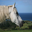
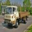
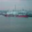
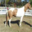
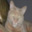
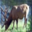
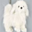
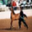
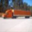
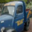

In [ ]:
tfds.as_dataframe(D_train.take(10), CIFAR10_info)

### Build a training pipeline

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; and we should opt to make our input values smaller. We will thus standardize values to be in the [0, 1] range.

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [ ]:
D_train = D_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
D_train = D_train.cache()
D_train = D_train.shuffle(CIFAR10_info.splits['train'].num_examples)
D_train = D_train.batch(128)
D_train = D_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

In [ ]:
D_val = D_val.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
D_val = D_val.batch(128)
D_val = D_val.cache()
D_val = D_val.prefetch(tf.data.AUTOTUNE)

### Build a testing pipeline

In [ ]:
D_test = D_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
D_test = D_test.batch(128)
D_test = D_test.cache()
D_test = D_test.prefetch(tf.data.AUTOTUNE)

# Create and train models

### Loss and Optimizer functions

We will choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. 

Adam is a popular optimizer for neural networks and is a good choice for deep neural networks & large datasets, because it can converge quickly under the given conditions.

Sparse Categorical Crossentropy is a commonly used loss function for multiclass classification problems. We will also use it because our target variable is represented as integers (instead of one-hot encoded vectors).

To view training and validation accuracy for each training epoch, we can simply pass the metrics argument to Model.compile.

In [ ]:
ADAM = tf.keras.optimizers.Adam()
SCCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
SCA = [tf.keras.metrics.SparseCategoricalAccuracy()]

The Lion Optimizer

In [ ]:
# Copyright 2023 Google Research. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""TF2 implementation of the Lion optimizer."""

import tensorflow.compat.v2 as tf


class Lion(tf.keras.optimizers.legacy.Optimizer):
  r"""Optimizer that implements the Lion algorithm."""

  def __init__(self,
               learning_rate=0.0001,
               beta_1=0.9,
               beta_2=0.99,
               wd=0,
               name='lion',
               **kwargs):
    """Construct a new Lion optimizer."""

    super(Lion, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self._set_hyper('wd', wd)

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Lion, self)._prepare_local(var_device, var_dtype, apply_state)

    beta_1_t = tf.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = tf.identity(self._get_hyper('beta_2', var_dtype))
    wd_t = tf.identity(self._get_hyper('wd', var_dtype))
    lr = apply_state[(var_device, var_dtype)]['lr_t']
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            beta_1_t=beta_1_t,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            one_minus_beta_2_t=1 - beta_2_t,
            wd_t=wd_t))

  @tf.function(jit_compile=True)
  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    var_t = var.assign_sub(
        coefficients['lr_t'] *
        (tf.math.sign(m * coefficients['beta_1_t'] +
                      grad * coefficients['one_minus_beta_1_t']) +
         var * coefficients['wd_t']))
    with tf.control_dependencies([var_t]):
      m.assign(m * coefficients['beta_2_t'] +
               grad * coefficients['one_minus_beta_2_t'])

  @tf.function(jit_compile=True)
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    m_t = m.assign(m * coefficients['beta_1_t'])
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))
    var_t = var.assign_sub(coefficients['lr'] *
                           (tf.math.sign(m_t) + var * coefficients['wd_t']))

    with tf.control_dependencies([var_t]):
      m_t = m_t.scatter_add(tf.IndexedSlices(-m_scaled_g_values, indices))
      m_t = m_t.assign(m_t * coefficients['beta_2_t'] /
                       coefficients['beta_1_t'])
      m_scaled_g_values = grad * coefficients['one_minus_beta_2_t']
      m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))

  def get_config(self):
    config = super(Lion, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'wd': self._serialize_hyperparameter('wd'),
    })
    return config

In [ ]:
LION = Lion()

Define function for visualising model performance

In [ ]:
def visualise(model_history, accuracy_metric, epochs):
  acc = model_history.history[accuracy_metric]
  val_accuracy_metric = 'val_'+accuracy_metric
  val_acc = model_history.history[val_accuracy_metric]

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## Traditional Neural Network

Creating the model

In [ ]:
neural_net = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(h, w, f)),
  tf.keras.layers.Dense(1024, activation='sigmoid'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(k)
])

neural_net.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

neural_net.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 3072)              0         
                                                                 
 dense_97 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_98 (Dense)            (None, 512)               524800    
                                                                 
 dense_99 (Dense)            (None, 256)               131328    
                                                                 
 dense_100 (Dense)           (None, 128)               32896     
                                                                 
 dense_101 (Dense)           (None, 10)                1290      
                                                                 
Total params: 3,837,066
Trainable params: 3,837,066
N

Train model, epochs=25, optimizer=ADAM

In [ ]:
epochs = 25

t1 = t.time()
neural_net_history = neural_net.fit(
    D_train,
    validation_data=D_val,
    epochs=epochs,
)
t2 = t.time()
print(t2-t1)

Epoch 1/25
352/352 [==============================] - 4s 5ms/step - loss: 1.9522 - sparse_categorical_accuracy: 0.2815 - val_loss: 1.8225 - val_sparse_categorical_accuracy: 0.3474
Epoch 2/25
352/352 [==============================] - 2s 6ms/step - loss: 1.7460 - sparse_categorical_accuracy: 0.3662 - val_loss: 1.7212 - val_sparse_categorical_accuracy: 0.3820
Epoch 3/25
352/352 [==============================] - 2s 6ms/step - loss: 1.6656 - sparse_categorical_accuracy: 0.3963 - val_loss: 1.6656 - val_sparse_categorical_accuracy: 0.4052
Epoch 4/25
352/352 [==============================] - 2s 5ms/step - loss: 1.6070 - sparse_categorical_accuracy: 0.4232 - val_loss: 1.6392 - val_sparse_categorical_accuracy: 0.4192
Epoch 5/25
352/352 [==============================] - 2s 5ms/step - loss: 1.5722 - sparse_categorical_accuracy: 0.4349 - val_loss: 1.5839 - val_sparse_categorical_accuracy: 0.4306
Epoch 6/25
352/352 [==============================] - 2s 5ms/step - loss: 1.5335 - sparse_categorica

In [ ]:
loss, accuracy = neural_net.evaluate(D_test)

79/79 [==============================] - 0s 3ms/step - loss: 1.4313 - sparse_categorical_accuracy: 0.4873


In [ ]:
it = D_test.as_numpy_iterator()

In [ ]:
sample = it.next()

In [ ]:
print(type(sample))
print(len(sample))
print(len(sample[0]))
print(len(sample[1]))

<class 'tuple'>
2
128
128


In [ ]:
x = sample[0][0]
y_true = sample[1][0]

In [ ]:
y_pred = neural_net.predict(tf.expand_dims(input=x, axis=0))
y_pred

1/1 [==============================] - 0s 94ms/step


array([[-1.3998038 , -1.4038389 ,  0.30976665,  2.2100775 ,  0.6492289 ,
         1.8976017 ,  0.8040381 ,  1.0984766 , -1.5327808 , -1.0350889 ]],
      dtype=float32)

Visualise model performance

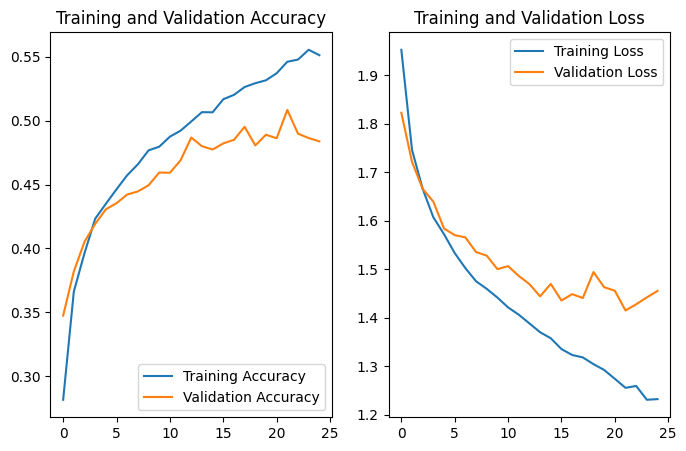

In [ ]:
visualise(neural_net_history, 'sparse_categorical_accuracy', epochs)

Our model consists of 5 layers; 4 hidden layers and 1 output layer with no activation function. The first and third layer are sigmoid activated and the other are two relu activated. It also uses the Adam optimizer, SCCE loss function and SCA as an accuracy metric.

The use of sigmoid and relu activation functions, as opposed to the simpler linear activation function, allows our Neural Network model (of 3,837,066 parameters) to reach an accuracy of at least 48%. This is quite low, as this means that our classification model most likely fails 52% of the time. But is very expected and understandable of a Traditional Neural Network.

At over 10 epochs, out of a total of 25 and taking approximately 55 seconds to finish, we also start noticing some overfitting over the training data. The model isn't as good at classifying the validation data, as it is with the training data.

### Traditional Neural Network 2

In [ ]:
neural_net_2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(h, w, 3)),
  tf.keras.layers.Dense(2048, activation='sigmoid'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(2048, activation='sigmoid'),
  tf.keras.layers.Dense(1024, activation='sigmoid'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(k)
])

neural_net_2.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    )

neural_net_2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 3072)              0         
                                                                 
 dense_110 (Dense)           (None, 2048)              6293504   
                                                                 
 dense_111 (Dense)           (None, 4096)              8392704   
                                                                 
 dense_112 (Dense)           (None, 2048)              8390656   
                                                                 
 dense_113 (Dense)           (None, 1024)              2098176   
                                                                 
 dense_114 (Dense)           (None, 512)               524800    
                                                                 
 dense_115 (Dense)           (None, 256)             

In [ ]:
epochs = 20

t1 = t.time()
neural_net_2_history = neural_net_2.fit(
    D_train,
    validation_data=D_val,
    epochs=epochs,
)
t2 = t.time()
print(t2-t1)

Epoch 1/20
352/352 [==============================] - 7s 12ms/step - loss: 2.3123 - sparse_categorical_accuracy: 0.0996 - val_loss: 2.3092 - val_sparse_categorical_accuracy: 0.0942
Epoch 2/20
352/352 [==============================] - 4s 11ms/step - loss: 2.1534 - sparse_categorical_accuracy: 0.1619 - val_loss: 2.0628 - val_sparse_categorical_accuracy: 0.1880
Epoch 3/20
352/352 [==============================] - 4s 11ms/step - loss: 2.0477 - sparse_categorical_accuracy: 0.1978 - val_loss: 2.0883 - val_sparse_categorical_accuracy: 0.1788
Epoch 4/20
352/352 [==============================] - 4s 11ms/step - loss: 2.0208 - sparse_categorical_accuracy: 0.2051 - val_loss: 2.0552 - val_sparse_categorical_accuracy: 0.1848
Epoch 5/20
352/352 [==============================] - 4s 11ms/step - loss: 2.0027 - sparse_categorical_accuracy: 0.2105 - val_loss: 2.0208 - val_sparse_categorical_accuracy: 0.1970
Epoch 6/20
352/352 [==============================] - 4s 11ms/step - loss: 1.9921 - sparse_cate

In [ ]:
loss, accuracy = neural_net_2.evaluate(D_test)

79/79 [==============================] - 0s 5ms/step - loss: 1.8809 - sparse_categorical_accuracy: 0.3046


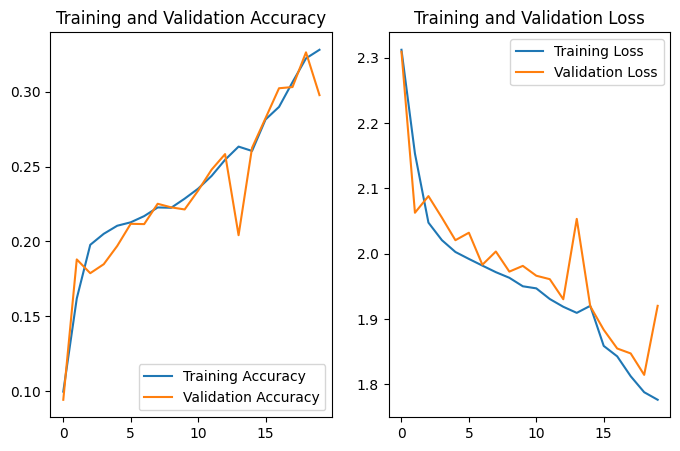

In [ ]:
visualise(neural_net_2_history, 'sparse_categorical_accuracy', epochs)

Our next model consists of 3 more hidden layers for a total of 8. This time, only the 2nd, 5th and 7th layers are relu activated, the rest are sigmoid. Even though it also uses the Adam optimizer, SCCE and SCA; because we use more sigmoid functions, and from having more layers and param eters in general, we expect our training to take longer. 

The more epochs and parameters we use, the higher the accuracy with respect to the training data. But also, with the more epochs we use, the more our traditional neural network model tends overfits to the training data. Not much overfitting is shown by our model, but at an accuracy of 30%, a loss of 1.88 and over 25 000 000 parameters; the model is able to poorly classify the training data, as relatively good as the validation data. Meaning it is most likely to make the wrong prediction approximately 70% of the time.

### Traditional neural Network 3

In [ ]:
neural_net_3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(h, w, 3)),
  tf.keras.layers.Dense(2048, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2048, activation='sigmoid'),
  tf.keras.layers.Dense(1024, activation='sigmoid'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(k)
])

neural_net_3.compile(
    optimizer = LION,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    )

neural_net_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_18 (Dense)            (None, 2048)              6293504   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 4096)              8392704   
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_20 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_21 (Dense)            (None, 1024)             

In [ ]:
epochs = 25
t1 = t.time()
neural_net_3_history = neural_net_3.fit(
    D_train,
    validation_data=D_val,
    epochs=epochs,
)
t2 = t.time()
print(t2-t1)

Epoch 1/25
352/352 [==============================] - 5s 11ms/step - loss: 3.2906 - sparse_categorical_accuracy: 0.1677 - val_loss: 2.7015 - val_sparse_categorical_accuracy: 0.2108
Epoch 2/25
352/352 [==============================] - 4s 11ms/step - loss: 2.3611 - sparse_categorical_accuracy: 0.2292 - val_loss: 2.0989 - val_sparse_categorical_accuracy: 0.2630
Epoch 3/25
352/352 [==============================] - 4s 11ms/step - loss: 1.9626 - sparse_categorical_accuracy: 0.2759 - val_loss: 1.8635 - val_sparse_categorical_accuracy: 0.3004
Epoch 4/25
352/352 [==============================] - 4s 11ms/step - loss: 1.8426 - sparse_categorical_accuracy: 0.3062 - val_loss: 1.8017 - val_sparse_categorical_accuracy: 0.3286
Epoch 5/25
352/352 [==============================] - 4s 12ms/step - loss: 1.7939 - sparse_categorical_accuracy: 0.3252 - val_loss: 1.7739 - val_sparse_categorical_accuracy: 0.3374
Epoch 6/25
352/352 [==============================] - 4s 11ms/step - loss: 1.7669 - sparse_cate

In [ ]:
loss, accuracy = neural_net_3.evaluate(D_test)

79/79 [==============================] - 0s 5ms/step - loss: 1.5175 - sparse_categorical_accuracy: 0.4543


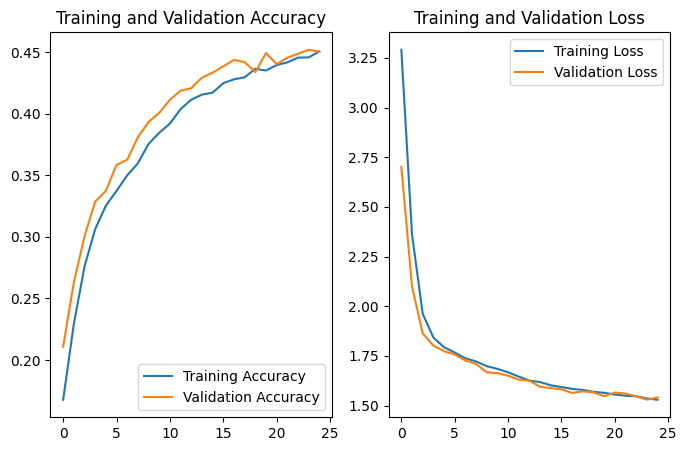

In [ ]:
visualise(neural_net_3_history, 'sparse_categorical_accuracy', epochs)

For our third and final TNN model, we keep the layers exactly the same as our previous model, except now we add some regularization. We add dropout regularization to the first, second and last hidden layers; and then add ridge regression to the last hidden layer. We also use a different, faster converging optimizer; the Lion optimizer; instead of Adam.

At 25 epochs, with an accuracy and loss of about 45% and 1.5 respectively, the model shows very little under and/or overfitting to the training data. This due to the high number of parameters (25,865,354), the Lion optimizer, the use of sigmoid and relu activation functions, and the added regularization which is normally used to particularly reduce overfitting. 

We notice this is more accurate than the previous model, but given it still just below even 50\% accuracy; shows the TNNs inherintly inefficient image classification capabilitites.

## Convolutional Neural Network

### Create baseline model CNN1 with less convolutional and pooling layers.

Our baseline model is a simple architecture that has only a few convolutional layers, filters and pooling layers. This approach may be suitable for simpler image classification tasks or datasets with less variation in features. We will begin with no regularization just as before with the TNNs. We will also begin with compiling with the ADAM optimizer.

In [ ]:
CNN1 = tf.keras.Sequential(
    layers = [
      tf.keras.layers.Input(shape=(h, w, 3)),
        
      tf.keras.layers.Conv2D(24, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((4,4), strides=(1,1)),
        
      tf.keras.layers.Conv2D(48, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Flatten(),
        
      tf.keras.layers.Dense(1024, activation='relu'),
        
      tf.keras.layers.Dense(k),
    ],
    name = 'CNN1'
)

CNN1.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = SCCE,
  metrics = SCA
)

Model summary

In [ ]:
CNN1.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 32, 32, 24)        1176      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 29, 29, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 29, 29, 48)        18480     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 14, 14, 48)       0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 9408)              0         
                                                                 
 dense_62 (Dense)            (None, 1024)              9634816

Train the model

In [ ]:
epochs = 25

CNN1_history = CNN1.fit(
  D_train,
  validation_data = D_val,
  epochs = epochs
)

Epoch 1/25
352/352 [==============================] - 6s 14ms/step - loss: 1.5948 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.3510 - val_sparse_categorical_accuracy: 0.5262
Epoch 2/25
352/352 [==============================] - 5s 14ms/step - loss: 1.1991 - sparse_categorical_accuracy: 0.5742 - val_loss: 1.1296 - val_sparse_categorical_accuracy: 0.6038
Epoch 3/25
352/352 [==============================] - 5s 13ms/step - loss: 1.0086 - sparse_categorical_accuracy: 0.6465 - val_loss: 0.9918 - val_sparse_categorical_accuracy: 0.6504
Epoch 4/25
352/352 [==============================] - 5s 14ms/step - loss: 0.8488 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.9234 - val_sparse_categorical_accuracy: 0.6822
Epoch 5/25
352/352 [==============================] - 5s 13ms/step - loss: 0.7116 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.9038 - val_sparse_categorical_accuracy: 0.6916
Epoch 6/25
352/352 [==============================] - 5s 14ms/step - loss: 0.5732 - sparse_cate

Evaluate model

In [ ]:
loss, accuracy = CNN1.evaluate(D_test)

79/79 [==============================] - 1s 7ms/step - loss: 2.6788 - sparse_categorical_accuracy: 0.6730


Visualize training results

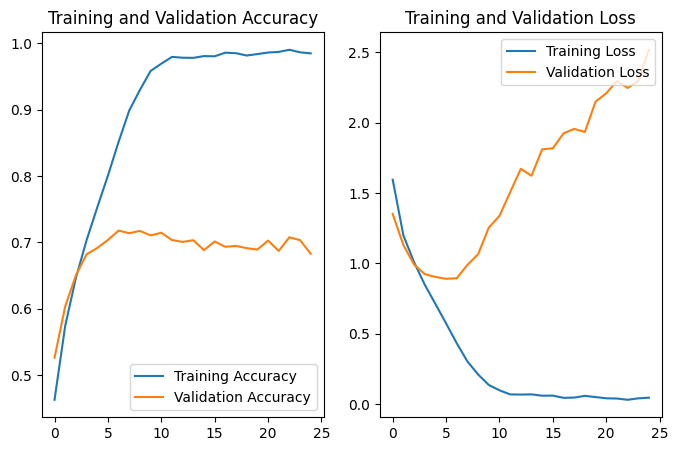

In [ ]:
visualise(CNN1_history, 'sparse_categorical_accuracy', epochs)

We see that already, the CNN already achieves about 67.30% test accuracy with about 2x less parameters as the traditional NN. We notice maximum accuracy scores of about 71% during training with validation loss < 0.9 in some epochs before overfitting kicks in. These values were not achieved by our most tweaked TNN.

The plots show that training and validation accuracy are off by large margins, as well as the training and validation losses. This is due to the overfitting that kicks in at about 5 epochs, which also causes model accuracy to drop

Hence, we will thus try to increase the overall performance of the model as we did with the TNNs.

#### CNN1 with dropout

To reduce overfitting and the large margins of discrapencies between training and validation loss and accuracy, we also introduce dropout regularization to the network. We do this in hopes of retaining some of the accuracy for the duration of the training.

We thus create another CNN1 but with dropout regularization

In [ ]:
CNN1_dropout = tf.keras.Sequential(
    layers = [
      tf.keras.layers.Input(shape=(h, w, 3)),
        
      tf.keras.layers.Conv2D(24, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((4,4), strides=(1,1)),
        
      tf.keras.layers.Conv2D(48, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(k),
    ],
    name = 'CNN1_dropout'
)

CNN1_dropout.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = SCCE,
  metrics = SCA
)

We train the model with the same 25 epochs

In [ ]:
epochs = 25

CNN1_droput_history = CNN1_dropout.fit(
  D_train,
  validation_data = D_val,
  epochs = epochs
)

Epoch 1/25
352/352 [==============================] - 7s 14ms/step - loss: 1.6083 - sparse_categorical_accuracy: 0.4731 - val_loss: 1.2197 - val_sparse_categorical_accuracy: 0.5682
Epoch 2/25
352/352 [==============================] - 5s 14ms/step - loss: 1.1743 - sparse_categorical_accuracy: 0.5834 - val_loss: 1.0372 - val_sparse_categorical_accuracy: 0.6370
Epoch 3/25
352/352 [==============================] - 5s 13ms/step - loss: 0.9988 - sparse_categorical_accuracy: 0.6489 - val_loss: 0.9636 - val_sparse_categorical_accuracy: 0.6690
Epoch 4/25
352/352 [==============================] - 5s 15ms/step - loss: 0.8824 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.8563 - val_sparse_categorical_accuracy: 0.7032
Epoch 5/25
352/352 [==============================] - 5s 14ms/step - loss: 0.7790 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.8444 - val_sparse_categorical_accuracy: 0.7146
Epoch 6/25
352/352 [==============================] - 5s 14ms/step - loss: 0.6969 - sparse_cate

In [ ]:
loss, accuracy = CNN1_dropout.evaluate(D_test)

79/79 [==============================] - 0s 5ms/step - loss: 1.1512 - sparse_categorical_accuracy: 0.7387


Visualise training results

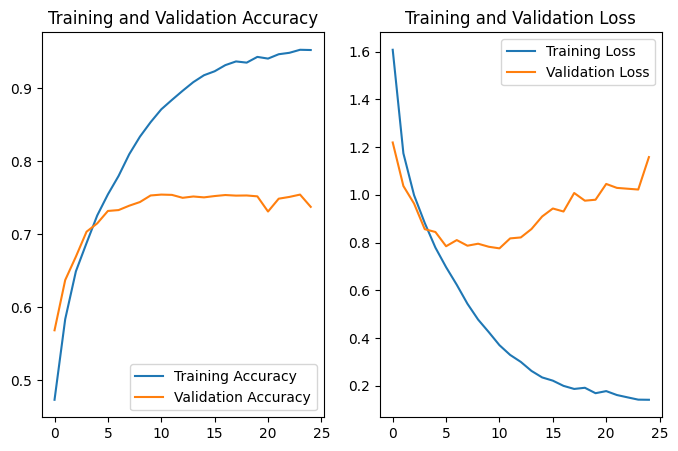

In [ ]:
visualise(CNN1_droput_history, 'sparse_categorical_accuracy', epochs)

We have managed to retain most of the validation accuracy, attaining a test accuracy of about 73.87%. However, this architecture still peaks at this accuracy level and continues to overfit. This leads us to add more complexity to the model.

#### CNN1 with L2 regularization

In [ ]:
l2_reg = tf.keras.regularizers.l2(0.00025)

In [ ]:
CNN1_L2 = tf.keras.Sequential(
    layers = [
      tf.keras.layers.Input(shape=(h, w, 3)),
        
      tf.keras.layers.Conv2D(24, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((4,4), strides=(1,1)),
        
      tf.keras.layers.Conv2D(48, 4, padding='same', kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(1024, kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(k),
    ],
    name = 'CNN1_L2'
)

CNN1_L2.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = SCCE,
  metrics = SCA
)

In [ ]:
epochs = 50

CNN1_L2_hist = CNN1_L2.fit(
  D_train,
  validation_data = D_val,
  epochs = epochs
)

Epoch 1/50
352/352 [==============================] - 6s 14ms/step - loss: 1.8902 - sparse_categorical_accuracy: 0.4470 - val_loss: 1.5128 - val_sparse_categorical_accuracy: 0.5132
Epoch 2/50
352/352 [==============================] - 5s 13ms/step - loss: 1.4737 - sparse_categorical_accuracy: 0.5188 - val_loss: 1.3610 - val_sparse_categorical_accuracy: 0.5652
Epoch 3/50
352/352 [==============================] - 5s 13ms/step - loss: 1.3833 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.2935 - val_sparse_categorical_accuracy: 0.6020
Epoch 4/50
352/352 [==============================] - 5s 13ms/step - loss: 1.3237 - sparse_categorical_accuracy: 0.5885 - val_loss: 1.2892 - val_sparse_categorical_accuracy: 0.6076
Epoch 5/50
352/352 [==============================] - 5s 13ms/step - loss: 1.2758 - sparse_categorical_accuracy: 0.6123 - val_loss: 1.2762 - val_sparse_categorical_accuracy: 0.6140
Epoch 6/50
352/352 [==============================] - 5s 14ms/step - loss: 1.2371 - sparse_cate

In [ ]:
loss, accuracy = CNN1_L2.evaluate(D_test)

79/79 [==============================] - 0s 6ms/step - loss: 1.1939 - sparse_categorical_accuracy: 0.7514


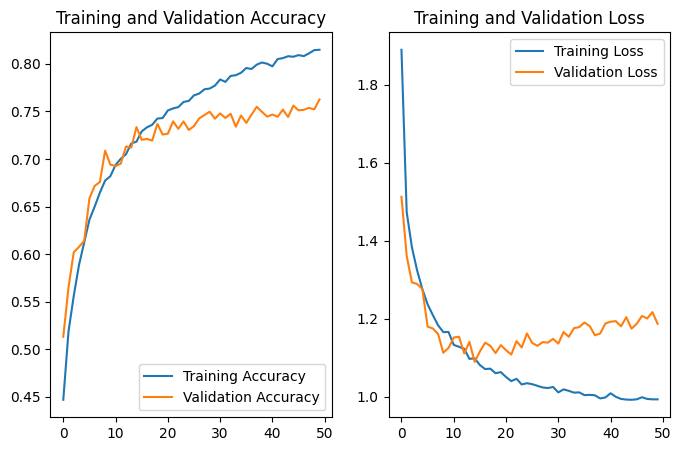

In [ ]:
visualise(CNN1_L2_hist, 'sparse_categorical_accuracy', epochs)

We set our regularization factor (a hyperparameter) to 0.00025 and applied L2 regularization to just 2 layers for now. This made training take a bit longer, that is, training accuracy did not quickly climb to > 90% as we saw previously and needed about 2x as much epochs to train. This is because the model is trying to minimize both the loss and the regularization term. Consequently, the divergence in the performance measurenent metrics was also reduced by a noticable margin. This helped the model achieve a test accuracy of about 75.14%.

### CNN2 : Added Convolutional & Pooling Layers

We have already seen the capabilities of CNNs in image classification from CNN1. Hence, in our next model, we aim for higher accuracy by ramping up the convolutional and pooling layers, as well as the filters . This enables the network to capture more complex patterns and features from the input images. This can be beneficial when dealing with more intricate image classification tasks or datasets with high variation in features.

In [ ]:
l2_reg = tf.keras.regularizers.l2(0.0005)

In [ ]:
CNN2 = tf.keras.Sequential(
    layers = [
      tf.keras.layers.Input(shape=(h, w, 3)),
        
      tf.keras.layers.Conv2D(48, 4, padding='same', kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.MaxPooling2D((4,4), strides=(1,1)),
        
      tf.keras.layers.Conv2D(128, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
        
      tf.keras.layers.Conv2D(256, 4, padding='same', kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.MaxPooling2D(strides=(2,2)),
        
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(2048, kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(k), 
    ],
    name = 'CNN2'
)

We compile the model with the Adam otimizer.

In [ ]:
CNN2.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = SCCE,
  metrics = SCA
)

Model summary

In [ ]:
CNN2.summary()

Model: "CNN2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 32, 32, 48)        2352      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 29, 29, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 29, 29, 128)       98432     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 256)       524544    
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 7, 7, 256)        0      

We train the model with the same 25 epochs

In [ ]:
epochs = 50

CNN2_his = CNN2.fit(
  D_train,
  validation_data=D_val,
  epochs=epochs
)

Epoch 1/50
352/352 [==============================] - 19s 48ms/step - loss: 1.8809 - sparse_categorical_accuracy: 0.5009 - val_loss: 1.4875 - val_sparse_categorical_accuracy: 0.5436
Epoch 2/50
352/352 [==============================] - 16s 46ms/step - loss: 1.4269 - sparse_categorical_accuracy: 0.5760 - val_loss: 1.3141 - val_sparse_categorical_accuracy: 0.6274
Epoch 3/50
352/352 [==============================] - 17s 47ms/step - loss: 1.3312 - sparse_categorical_accuracy: 0.6221 - val_loss: 1.2338 - val_sparse_categorical_accuracy: 0.6620
Epoch 4/50
352/352 [==============================] - 17s 47ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.6614 - val_loss: 1.2551 - val_sparse_categorical_accuracy: 0.6698
Epoch 5/50
352/352 [==============================] - 17s 48ms/step - loss: 1.2071 - sparse_categorical_accuracy: 0.6838 - val_loss: 1.1270 - val_sparse_categorical_accuracy: 0.7208
Epoch 6/50
352/352 [==============================] - 17s 47ms/step - loss: 1.1656 - spars

In [ ]:
loss, accuracy = CNN2.evaluate(D_test)

79/79 [==============================] - 1s 13ms/step - loss: 1.1263 - sparse_categorical_accuracy: 0.8085


Visualise training results

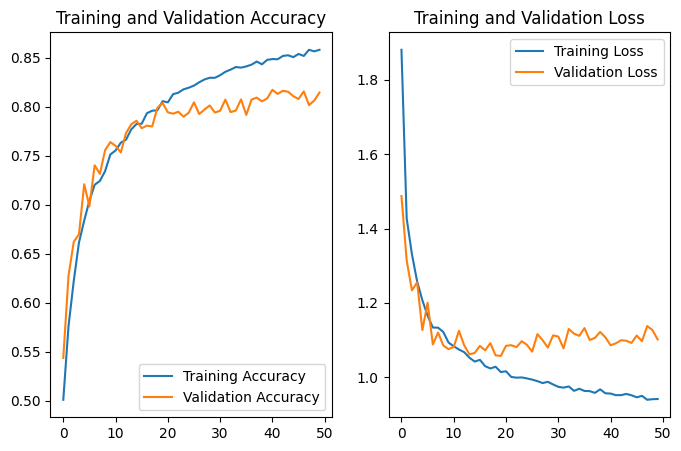

In [ ]:
visualise(CNN2_his, 'sparse_categorical_accuracy', epochs)

This time we set our regularization factor to 0.0005 and added l2 regularization in alternating layers in the network since it now has more layers. As expected, adding more complexity to the model improved its validation accuracy, we see it reaching 80% during training and a final test accuracy of 80.85% as well.

### CNN2 with Lion optimizer

We now try the Lion optimizer on the same network, since it has demonstrated that it can aid tasks such as image classification attain better results. We investigate that with our next model.

In [ ]:
l2_reg = tf.keras.regularizers.l2(0.0005)

In [ ]:
CNN2_L = tf.keras.Sequential(
    layers = [
      tf.keras.layers.Input(shape=(h, w, 3)),
        
      tf.keras.layers.Conv2D(48, 4, padding='same', kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.MaxPooling2D((4,4), strides=(1,1)),
        
      tf.keras.layers.Conv2D(128, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
        
      tf.keras.layers.Conv2D(256, 4, padding='same', kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.MaxPooling2D(strides=(2,2)),
        
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(2048, kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(k)
    ],
    name = 'CNN2_L'
)

In [ ]:
CNN2_L.compile(
  optimizer = LION,
  loss = SCCE,
  metrics = SCA
)

We now stop training at 20 epochs since we have observed that our models already diverge in terms of their performance measurement metrics by then.

In [ ]:
epochs = 50

CNN2L_his = CNN2_L.fit(
  D_train,
  validation_data=D_val,
  epochs=epochs
)

Epoch 1/50
352/352 [==============================] - 17s 46ms/step - loss: 2.3344 - sparse_categorical_accuracy: 0.5094 - val_loss: 1.5304 - val_sparse_categorical_accuracy: 0.6006
Epoch 2/50
352/352 [==============================] - 16s 46ms/step - loss: 1.4440 - sparse_categorical_accuracy: 0.6320 - val_loss: 1.3345 - val_sparse_categorical_accuracy: 0.6820
Epoch 3/50
352/352 [==============================] - 16s 47ms/step - loss: 1.3081 - sparse_categorical_accuracy: 0.6999 - val_loss: 1.2632 - val_sparse_categorical_accuracy: 0.7276
Epoch 4/50
352/352 [==============================] - 17s 47ms/step - loss: 1.2409 - sparse_categorical_accuracy: 0.7363 - val_loss: 1.1993 - val_sparse_categorical_accuracy: 0.7560
Epoch 5/50
352/352 [==============================] - 17s 47ms/step - loss: 1.1811 - sparse_categorical_accuracy: 0.7588 - val_loss: 1.1513 - val_sparse_categorical_accuracy: 0.7770
Epoch 6/50
352/352 [==============================] - 17s 48ms/step - loss: 1.1325 - spars

In [ ]:
loss, accuracy = CNN2_L.evaluate(D_test)

79/79 [==============================] - 1s 13ms/step - loss: 1.0306 - sparse_categorical_accuracy: 0.8297


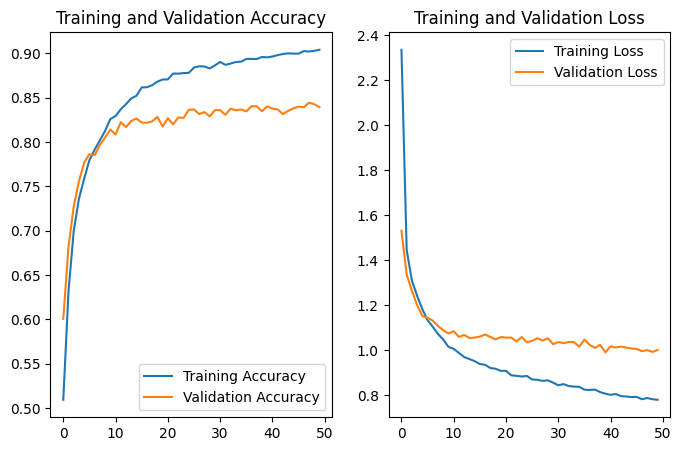

In [ ]:
visualise(CNN2L_his, 'sparse_categorical_accuracy', epochs)

As expected, the Lion optimizer has aided in increasing the accuracy of our model. We also notice how "smoother" the curves have become, indicating that training was more stable with the Lion optimizer. The final test accuracy has increased to 82.97%

### **Model 3 : Increased Filter Sizes**

Increasing the filter size in convolutional layers allows the network to capture larger and more global features in the input images. This can be beneficial when dealing with larger images or when the target objects or patterns have a broader spatial extent.

In [ ]:
l2_reg = tf.keras.regularizers.l2(0.001)

In [ ]:
CNN3 = tf.keras.Sequential(
    layers = [
      tf.keras.layers.Input(shape=(h, w, 3)),
        
      tf.keras.layers.Conv2D(96, 4, padding='same', kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.MaxPooling2D((4,4), strides=(1,1)),
        
      tf.keras.layers.Conv2D(256, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
        
      tf.keras.layers.Conv2D(384, 4, padding='same', kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.MaxPooling2D(strides=(1,1)),
        
      tf.keras.layers.Conv2D(256, 4, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(strides=(2,2)),
        
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(4096, kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.Dropout(0.4),
        
      tf.keras.layers.Dense(4096, kernel_regularizer=l2_reg, activation='relu'),
      tf.keras.layers.Dropout(0.3),
        
      tf.keras.layers.Dense(k), 
    ],
    name = 'CNN3'
)

In [ ]:
CNN3.compile(
  optimizer = LION,
  loss = SCCE,
  metrics = SCA
)

In [ ]:
CNN3.summary()

Model: "CNN3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 32, 32, 96)        4704      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 29, 29, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 29, 29, 256)       393472    
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 14, 14, 384)       1573248   
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 13, 13, 384)      0      

In [ ]:
epochs = 75

CNN3_hist = CNN3.fit(
  D_train,
  validation_data=D_val,
  epochs=epochs
)

Epoch 1/75
352/352 [==============================] - 55s 153ms/step - loss: 4.1387 - sparse_categorical_accuracy: 0.4485 - val_loss: 1.7977 - val_sparse_categorical_accuracy: 0.5756
Epoch 2/75
352/352 [==============================] - 55s 155ms/step - loss: 1.5687 - sparse_categorical_accuracy: 0.6114 - val_loss: 1.3859 - val_sparse_categorical_accuracy: 0.6770
Epoch 3/75
352/352 [==============================] - 55s 157ms/step - loss: 1.3595 - sparse_categorical_accuracy: 0.6860 - val_loss: 1.2531 - val_sparse_categorical_accuracy: 0.7320
Epoch 4/75
352/352 [==============================] - 56s 158ms/step - loss: 1.2319 - sparse_categorical_accuracy: 0.7366 - val_loss: 1.2039 - val_sparse_categorical_accuracy: 0.7512
Epoch 5/75
352/352 [==============================] - 56s 159ms/step - loss: 1.1536 - sparse_categorical_accuracy: 0.7690 - val_loss: 1.1230 - val_sparse_categorical_accuracy: 0.7878
Epoch 6/75
352/352 [==============================] - 55s 156ms/step - loss: 1.0893 -

In [ ]:
loss, accuracy = CNN3.evaluate(D_test)

79/79 [==============================] - 3s 39ms/step - loss: 1.0163 - sparse_categorical_accuracy: 0.8322


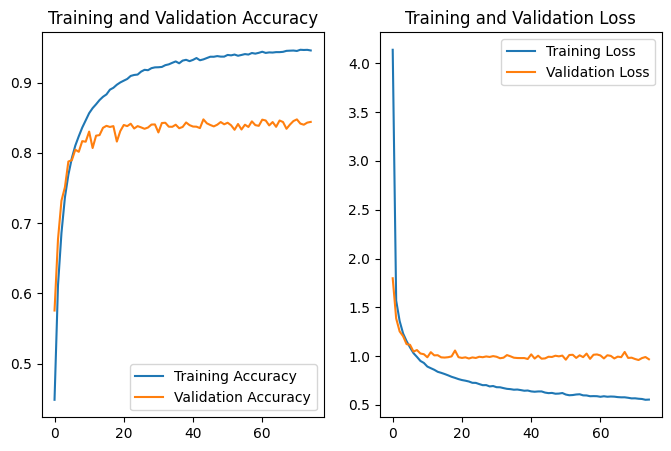

In [ ]:
visualise(CNN3_hist, 'sparse_categorical_accuracy', epochs)

### Visualizing training results

In [ ]:
visualise(history_1, 'sparse_categorical_accuracy', epochs, 'model-2A')

In [ ]:
visualise(history_2, 'sparse_categorical_accuracy', epochs, 'model-2B')

In [ ]:
visualise(history_3, 'sparse_categorical_accuracy', epochs, 'model-2C')

In [ ]:
print(times)